### Exploring the pixelpar Allen institute dataset

In this notebook we explore the dataset using the EcephysSession class provided by Allen Institute to load the data stored locally. For furter reference check the quick-start notebooks in [their website](https://allensdk.readthedocs.io/en/latest/visual_coding_neuropixels.html) in which this notebook is based on.

In [1]:
import numpy             as np
import xarray            as xr
import pandas            as pd
import matplotlib.pyplot as plt

from tqdm                import tqdm

from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession
from allensdk.brain_observatory.ecephys.visualization   import plot_mean_waveforms, plot_spike_counts, raster_plot

pd.set_option("display.max_columns", None)

### Defining dicitionary with regions and areas' names

In [2]:
region_dict = {'cortex' :   ['VISp', 'VISl', 'VISrl', 'VISam', 'VISpm', 'VIS', 'VISal','VISmma','VISmmp','VISli'],
               'thalamus' : ['LGd','LD', 'LP', 'VPM', 'TH', 'MGm','MGv','MGd','PO','LGv','VL',
                             'VPL','POL','Eth','PoT','PP','PIL','IntG','IGL','SGN','VPL','PF','RT'],
               'hippocampus' : ['CA1', 'CA2','CA3', 'DG', 'SUB', 'POST','PRE','ProS','HPF'],
               'midbrain':     ['MB','SCig','SCiw','SCsg','SCzo','PPT','APN','NOT','MRN','OP','LT','RPF','CP']}

color_dict = {'cortex' :      '#08858C',
              'thalamus' :    '#FC6B6F',
              'hippocampus' : '#7ED04B',
              'midbrain' :    '#FC9DFE'}

### Reading the data stored localy

`EcephysSession` objects contain methods and properties that access the data within an ecephys NWB file and cache it in memory.

In [3]:
nwb_path = '../data/ecephys_cache_dir/session_721123822/session_721123822.nwb'
'''
session = EcephysSession.from_nwb_path(nwb_path, api_kwargs={
                                       "amplitude_cutoff_maximum": np.inf,
                                       "presence_ratio_minimum":  -np.inf,
                                       "isi_violations_maximum":   np.inf
                                       })
'''
session = EcephysSession.from_nwb_path(nwb_path)

This session object has some important metadata, such as the date and time at which the recording session started:

In [4]:
print(f"session {session.ecephys_session_id} was acquired in {session.session_start_time}")

session 721123822 was acquired in 2019-01-08 16:25:35-08:00


We'll now jump in to accessing our session's data. If you ever want a complete documented list of the attributes and methods defined on `EcephysSession`, you can run `help(EcephysSession)` (or in a jupyter notebook: `EcephysSession?`).

### Sorted units

Units are putative neurons, clustered from raw voltage traces using Kilosort 2. Each unit is associated with a single *peak channel* on a single probe, though its spikes might be picked up with some attenuation on multiple nearby channels. Each unit is assigned a unique integer identifier ("unit_id") which can be used to look up its  spike times and its mean waveform.

The units for a session are recorded in an attribute called, fittingly, `units`. This is a `pandas.DataFrame` whose index is the unit id and whose columns contain summary information about the unit, its peak channel, and its associated probe.

In [5]:
session.units.head()

,amplitude_cutoff,firing_rate,presence_ratio,snr,waveform_velocity_below,isolation_distance,silhouette_score,waveform_velocity_above,nn_miss_rate,waveform_PT_ratio,d_prime,cumulative_drift,L_ratio,waveform_repolarization_slope,max_drift,peak_channel_id,nn_hit_rate,local_index_unit,cluster_id,waveform_halfwidth,waveform_duration,waveform_recovery_slope,waveform_amplitude,waveform_spread,isi_violations,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,ecephys_structure_acronym,probe_vertical_position,probe_horizontal_position,probe_id,channel_local_index,ecephys_structure_id,probe_has_lfp_data,probe_lfp_sampling_rate,location,probe_description,probe_sampling_rate
unit_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
950907205,0.012123,14.739577,0.99,2.838052,NaN,129.172458,0.193312,-0.892797,0.004831,1.054721,5.252421,250.13,0.002403,0.279423,17.93,850243987,0.997333,1,1,0.109883,0.151089,-0.244173,101.262915,40.0,0.005100,8456.0,3144.0,3144.0,MB,40,27,760213137,3,313.0,True,1249.998783,See electrode locations,probeA,29999.970785
950907524,0.002313,1.448536,0.99,4.285082,0.686767,50.450187,0.143138,0.068677,0.001834,0.558508,5.439966,279.40,0.004085,0.561527,9.72,850243991,0.925725,151,154,0.164824,0.357119,-0.123923,136.843200,60.0,0.000000,8447.0,3127.0,3127.0,MB,60,11,760213137,5,313.0,True,1249.998783,See electrode locations,probeA,29999.970785
950907209,0.084063,0.040263,0.96,3.343694,0.000000,19.926951,NaN,0.156975,0.000467,0.637890,3.246909,0.00,0.023899,0.469697,0.32,850243991,0.000000,3,3,0.178559,0.343384,-0.115789,114.131278,70.0,0.000000,8447.0,3127.0,3127.0,MB,60,11,760213137,5,313.0,True,1249.998783,See electrode locations,probeA,29999.970785
950907526,0.024568,0.376838,0.99,2.697075,0.000000,66.773857,0.092951,0.595198,0.000235,0.576049,5.347055,532.46,0.000197,0.356753,26.83,850243997,0.961111,152,155,0.123618,0.219765,-0.086945,85.886190,110.0,0.000000,8433.0,3102.0,3102.0,MB,100,43,760213137,8,313.0,True,1249.998783,See electrode locations,probeA,29999.970785
950907216,0.002750,8.277175,0.99,2.387977,-0.343384,89.982684,0.120142,-0.480737,0.001606,0.651440,5.657655,262.20,0.002184,0.327093,30.28,850244003,0.997333,6,6,0.109883,0.206030,-0.101327,79.630785,80.0,0.007249,8419.0,3077.0,3077.0,MB,120,27,760213137,11,313.0,True,1249.998783,See electrode locations,probeA,29999.970785


As a `pandas.DataFrame` the units table supports many straightforward filtering operations:

In [6]:
# how many units have signal to noise ratios that are greater than 4?
print(f'{session.units.shape[0]} units total.')
units_with_very_high_snr = session.units[session.units['snr'] > 4]
print(f'{units_with_very_high_snr.shape[0]}  units have SNR > 4.')

444 units total.
60  units have SNR > 4.


### Stimulus presentations

During the course of a session, visual stimuli are presented on a monitor to the subject. We call intervals of time where a specific stimulus is presented (and its parameters held constant!) a *stimulus presentation*.

You can find information about the stimulus presentations that were displayed during a session by accessing the `stimulus_presentations` attribute on your `EcephysSession` object. 

In [7]:
session.stimulus_presentations.head()

,color,contrast,frame,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,x_position,y_position,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
0,null,null,null,null,null,null,null,26.219072,null,spontaneous,86.285852,null,null,null,60.066780,0
1,null,0.8,null,45,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,86.285852,0,gabors,86.519369,4,-10,-20,0.233517,1
2,null,0.8,null,45,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,86.519369,0,gabors,86.769565,4,-40,-30,0.250196,2
3,null,0.8,null,90,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,86.769565,0,gabors,87.019762,4,-10,-10,0.250196,3
4,null,0.8,null,0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,87.019762,0,gabors,87.269958,4,20,-10,0.250196,4


Like the units table, this is a `pandas.DataFrame`. Each row corresponds to a stimulus presentation and lists the time (on the session's master clock, in seconds) when that presentation began and ended as well as the kind of stimulus that was presented (the "stimulus_name" column) and the parameter values that were used for that presentation. Many of these parameter values don't overlap between stimulus classes, so the stimulus_presentations table uses the string `"null"` to indicate an inapplicable parameter. The index is named "stimulus_presentation_id" and many methods on `EcephysSession` use these ids.

Some of the columns bear a bit of explanation:
- stimulus_block : A block consists of multiple presentations of the same stimulus class presented with (probably) different parameter values. If during a session stimuli were presented in the following order:
    - drifting gratings
    - static gratings
    - drifting gratings
    then the blocks for that session would be [0, 1, 2]. The gray period stimulus (just a blank gray screen) never gets a block.
- duration : this is just stop_time - start_time, precalculated for convenience.

What kinds of stimuli were presented during this session? Pandas makes it easy to find out:

In [8]:
session.stimulus_names # just the unique values from the 'stimulus_name' column

['spontaneous',
 'gabors',
 'flashes',
 'drifting_gratings',
 'natural_movie_three',
 'natural_movie_one',
 'static_gratings',
 'natural_scenes']

We can also obtain the `stimulus epochs` - blocks of time for which a particular kind of stimulus was presented - for this session.

In [9]:
session.get_stimulus_epochs()

,start_time,stop_time,duration,stimulus_name,stimulus_block
0,26.219072,86.285852,60.066780,spontaneous,null
1,86.285852,998.280652,911.994800,gabors,0
2,998.280652,1287.272022,288.991370,spontaneous,null
3,1287.272022,1585.771259,298.499237,flashes,1
4,1585.771259,1587.522722,1.751463,spontaneous,null
5,1587.522722,2187.023348,599.500626,drifting_gratings,2
6,2187.023348,2218.049252,31.025904,spontaneous,null
7,2218.049252,2818.550752,600.501500,natural_movie_three,3
8,2818.550752,2848.575812,30.025060,spontaneous,null
9,2848.575812,3148.826512,300.250700,natural_movie_one,4


If you are only interested in a subset of stimuli, you can either filter using pandas or using the `get_stimulus_table` convience method:

In [10]:
session.get_stimulus_table(['drifting_gratings']).head()

,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3798,0.8,315,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,1587.522722,2,drifting_gratings,1589.524372,15,2.00165,246
3799,0.8,0,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,1590.525218,2,drifting_gratings,1592.526888,4,2.00167,247
3800,0.8,315,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,1593.527732,2,drifting_gratings,1595.529392,4,2.00166,248
3801,0.8,90,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,1596.530228,2,drifting_gratings,1598.531898,15,2.00167,249
3802,0.8,270,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,1599.532762,2,drifting_gratings,1601.534412,15,2.00165,250


We might also want to know what the total set of available parameters is. The `get_stimulus_parameter_values` method provides a dictionary mapping stimulus parameters to the set of values that were applied to those parameters:

In [11]:
for key, values in session.get_stimulus_parameter_values().items():
    print(f'{key}: {values}')

color: [-1.0 1.0]
contrast: [0.8 1.0]
frame: [-1.0 0.0 1.0 ... 3597.0 3598.0 3599.0]
orientation: [0.0 30.0 45.0 60.0 90.0 120.0 135.0 150.0 180.0 225.0 270.0 315.0]
phase: ['0.0' '0.25' '0.5' '0.75' '[0.0, 0.0]' '[21211.93333333, 21211.93333333]'
 '[3644.93333333, 3644.93333333]']
size: ['[1920.0, 1080.0]' '[20.0, 20.0]' '[250.0, 250.0]' '[300.0, 300.0]']
spatial_frequency: ['0.02' '0.04' '0.08' '0.16' '0.32' '[0.0, 0.0]']
temporal_frequency: [1.0 2.0 4.0 8.0 15.0]
x_position: [-40.0 -30.0 -20.0 -10.0 0.0 10.0 20.0 30.0 40.0]
y_position: [-40.0 -30.0 -20.0 -10.0 0.0 10.0 20.0 30.0 40.0]


Each distinct state of the monitor is called a "stimulus condition". Each presentation in the stimulus presentations table exemplifies such a condition. This is encoded in its stimulus_condition_id field.

To get the full list of conditions presented in a session, use the stimulus_conditions attribute:

In [12]:
session.stimulus_conditions.head()

,color,contrast,frame,mask,opacity,orientation,phase,size,spatial_frequency,stimulus_name,temporal_frequency,units,x_position,y_position,color_triplet
stimulus_condition_id,,,,,,,,,,,,,,,
0,null,null,null,null,null,null,null,null,null,spontaneous,null,null,null,null,null
1,null,0.8,null,circle,1,45,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,gabors,4,deg,-10,-20,"[1.0, 1.0, 1.0]"
2,null,0.8,null,circle,1,45,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,gabors,4,deg,-40,-30,"[1.0, 1.0, 1.0]"
3,null,0.8,null,circle,1,90,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,gabors,4,deg,-10,-10,"[1.0, 1.0, 1.0]"
4,null,0.8,null,circle,1,0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,gabors,4,deg,20,-10,"[1.0, 1.0, 1.0]"


### Spike data

The `EcephysSession` object holds spike times (in seconds on the session master clock) for each unit. These are stored in a dictionary, which maps unit ids (the index values of the units table) to arrays of spike times.

In [13]:
 # grab an arbitrary (though high-snr!) unit (we made units_with_high_snr above)
high_snr_unit_ids = units_with_very_high_snr.index.values
unit_id           = high_snr_unit_ids[0]

print(f"{len(session.spike_times[unit_id])} spikes were detected for unit {unit_id} at times:")
session.spike_times[unit_id]

/home/vinicius/.local/lib/python3.6/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:1093: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',"


14211 spikes were detected for unit 950907524 at times:


array([2.34882425e+00, 2.54585777e+00, 2.67202456e+00, ...,
       9.80684684e+03, 9.80757664e+03, 9.81106228e+03])

You can also obtain spikes tagged with the stimulus presentation during which they occurred:

In [14]:
# get spike times from the first block of drifting gratings presentations 
drifting_gratings_presentation_ids = session.stimulus_presentations.loc[
    (session.stimulus_presentations['stimulus_name'] == 'drifting_gratings')
].index.values

times = session.presentationwise_spike_times(
    stimulus_presentation_ids=drifting_gratings_presentation_ids,
    unit_ids=high_snr_unit_ids
)

times.head()

,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset
spike_time,,,
1587.526268,3798,950907406,0.003546
1587.527800,3798,950907987,0.005078
1587.528701,3798,950908074,0.005978
1587.534334,3798,950908275,0.011612
1587.534667,3798,950908204,0.011945


We can make raster plots of these data:

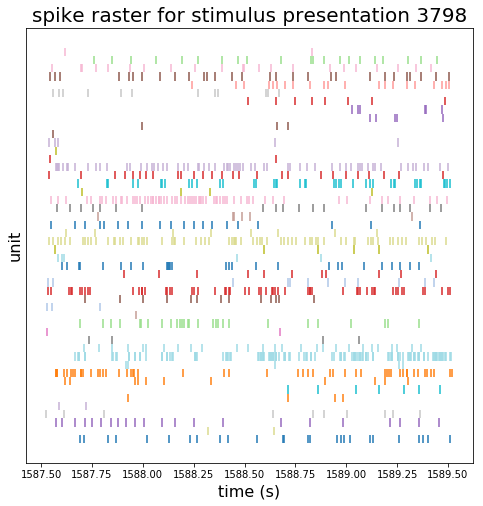

color                                                null
contrast                                              0.8
frame                                                null
orientation                                           315
phase                    [21211.93333333, 21211.93333333]
size                                       [250.0, 250.0]
spatial_frequency                                    0.04
start_time                                        1587.52
stimulus_block                                          2
stimulus_name                           drifting_gratings
stop_time                                         1589.52
temporal_frequency                                     15
x_position                                           null
y_position                                           null
duration                                          2.00165
stimulus_condition_id                                 246
Name: 3798, dtype: object

In [15]:
first_drifting_grating_presentation_id = times['stimulus_presentation_id'].values[0]
plot_times = times[times['stimulus_presentation_id'] == first_drifting_grating_presentation_id]

fig = raster_plot(plot_times, title=f'spike raster for stimulus presentation {first_drifting_grating_presentation_id}')
plt.show()

# also print out this presentation
session.stimulus_presentations.loc[first_drifting_grating_presentation_id]

We can also plot the whole raster plot and color each spike-train accordingly to its brain region

In [16]:
units = session.units

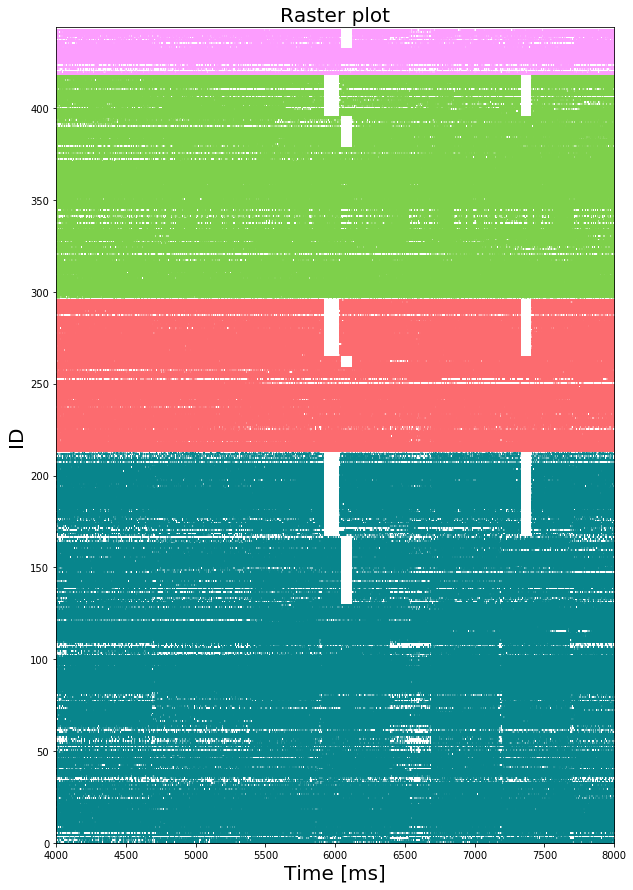

In [17]:
plt.figure(figsize=(10,15))
count = 0
for idx, region in enumerate(region_dict.keys()):
    ids = units[units.ecephys_structure_acronym.isin(region_dict[region])].index.values
    for i in ids:
        plt.plot(session.spike_times[i], [count]*len(session.spike_times[i]), '|', ms=1, color = color_dict[region])
        count += 1
plt.xlim([4000,8000])
plt.ylim([0,count])
plt.title('Raster plot', fontsize=20)
plt.xlabel('Time [ms]', fontsize=20)
plt.ylabel('ID', fontsize=20)
plt.savefig('img/raster_plot_session_721123822.png', dpi=150)

### Suggested exercises

If you would hands-on experience with the `EcephysSession` class, please consider working through some of these excercises.

- **tuning curves** : Pick a stimulus parameter, such as orientation on drifting gratings trials. Plot the mean and standard error of spike counts for each unit at each value of this parameter.
- **signal correlations** : Calculate unit-pairwise correlation coefficients on the tuning curves for a stimulus parameter of interest (`numpy.corrcoef` might be useful).
- **noise correlations** : Build for each unit a vector of spike counts across repeats of the same stimulus condition. Compute unit-unit correlation coefficients on these vectors.
- **cross-correlations** : Start with two spike trains. Call one of them "fixed" and the other "moving". Choose a set of time offsets and for each offset:
    1. apply the offset to the spike times in the moving train
    2. compute the correlation coefficient between the newly offset moving train and the fixed train.
    You should then be able to plot the obtained correlation coeffients as a function of the offset. 
- **unit clustering** : First, extract a set of unitwise features. You might draw these from the mean waveforms, for instance:
    - mean duration between waveform peak and trough (on the unit's peak channel)
    - the amplitude of the unit's trough
    
    or you might draw them from the unit's spike times, such as:
    - median inter-spike-interval
    
    or from metadata
    - CCF structure
    
    With your features in hand, attempt an unsupervised classification of the units. If this seems daunting, check out the [scikit-learn unsupervised learning documention](https://scikit-learn.org/stable/modules/clustering.html#clustering) for library code and examples.
- **population decoding** : Using an `EcephysSession` (and filtering to some stimuli and units of interest), build two aligned matrices:
    1. A matrix whose rows are stimulus presentations, columns are units, and values are spike counts.
    2. A matrix whose rows are stimulus presentations and whose columns are stimulus parameters.
    
    Using these matrices, train a classifier to predict stimulus conditions (sets of stimulus parameter values) from presentationwise population spike counts. See the [scikit-learn supervised learning tutorial](https://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html) for a guide to supervised learning in Python.

#### 1. Tuning Curves

In [30]:
# Printing stimulus informations
session.stimulus_conditions.head()

,color,contrast,frame,mask,opacity,orientation,phase,size,spatial_frequency,stimulus_name,temporal_frequency,units,x_position,y_position,color_triplet
stimulus_condition_id,,,,,,,,,,,,,,,
0,null,null,null,null,null,null,null,null,null,spontaneous,null,null,null,null,null
1,null,0.8,null,circle,1,45,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,gabors,4,deg,-10,-20,"[1.0, 1.0, 1.0]"
2,null,0.8,null,circle,1,45,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,gabors,4,deg,-40,-30,"[1.0, 1.0, 1.0]"
3,null,0.8,null,circle,1,90,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,gabors,4,deg,-10,-10,"[1.0, 1.0, 1.0]"
4,null,0.8,null,circle,1,0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,gabors,4,deg,20,-10,"[1.0, 1.0, 1.0]"


In [44]:
session.stimulus_presentations.head()

,color,contrast,frame,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,x_position,y_position,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
0,null,null,null,null,null,null,null,26.219072,null,spontaneous,86.285852,null,null,null,60.066780,0
1,null,0.8,null,45,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,86.285852,0,gabors,86.519369,4,-10,-20,0.233517,1
2,null,0.8,null,45,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,86.519369,0,gabors,86.769565,4,-40,-30,0.250196,2
3,null,0.8,null,90,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,86.769565,0,gabors,87.019762,4,-10,-10,0.250196,3
4,null,0.8,null,0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,87.019762,0,gabors,87.269958,4,20,-10,0.250196,4


In [ ]:
session.stimulus_presentations

In [41]:
# Index of drifiting gratings presentations
idx_drifting_gratings = session.stimulus_presentations.loc[
     (session.stimulus_presentations['orientation'] == 90.0)
     ].index.values#session.get_stimulus_table(['drifting_gratings']).index.values

In [45]:
print(idx_drifting_gratings)

[    3     6     9 ... 70375 70378 70380]


In [42]:
session.stimulus_conditions.orientation.loc[idx_drifting_gratings]

/opt/ohpc/pub/libs/gnu8/python/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


stimulus_condition_id
3         90
6         90
9         90
17        90
18        90
19        90
20        90
21        90
25        45
27         0
32         0
33        45
35        45
41        90
42         0
47        45
50        90
51         0
52        45
55        90
58         0
64        90
65        45
66        45
71         0
75        90
76         0
77         0
80        45
82        45
        ... 
70260    NaN
70263    NaN
70272    NaN
70274    NaN
70276    NaN
70284    NaN
70287    NaN
70289    NaN
70293    NaN
70296    NaN
70299    NaN
70302    NaN
70307    NaN
70309    NaN
70313    NaN
70323    NaN
70324    NaN
70330    NaN
70337    NaN
70339    NaN
70343    NaN
70344    NaN
70360    NaN
70362    NaN
70366    NaN
70372    NaN
70374    NaN
70375    NaN
70378    NaN
70380    NaN
Name: orientation, Length: 2263, dtype: object

In [15]:
unique_orientations = np.unique( session.stimulus_conditions.orientation[session.stimulus_conditions.stimulus_name=='drifting_gratings'].values )

TypeError: '<' not supported between instances of 'str' and 'float'

In [19]:
print(unique_orientations)

[0.0 30.0 45.0 60.0 90.0 120.0 135.0 150.0 180.0 225.0 270.0 315.0]


In [48]:
# Tunning curve, mean and std
f_mu  = np.zeros_like(unique_orientations)
f_sig = np.zeros_like(unique_orientations)

for i in tqdm( range( len(unique_orientations) ) ):
    ids = session.stimulus_presentations.loc[
         (session.stimulus_presentations['orientation'] == unique_orientations[i])
         ].index.values
    
    times = session.presentationwise_spike_times(
    stimulus_presentation_ids=ids,
    unit_ids=session.units.index.values)
    
    f_mu[i]  = times.groupby(['unit_id']).apply(len).values.mean()
    f_sig[i] = times.groupby(['unit_id']).apply(len).values.std() #/ np.sqrt(len(times.groupby(['unit_id'])))


100%|██████████| 12/12 [02:08<00:00, 10.73s/it]


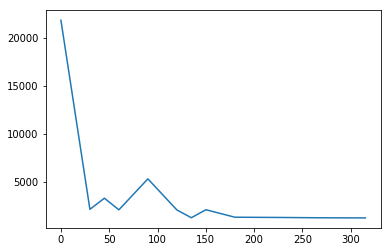

In [50]:
plt.plot(unique_orientations, f_mu)
#plt.fill_between(unique_orientations, f_mu-f_sig, f_mu+f_sig, alpha=0.2)

In [44]:
f_mu

array([21815.734234234234, 2114.936936936937, 3274.114864864865,
       2063.7725225225226, 5289.707207207207, 2052.0405405405404,
       1238.7815315315315, 2072.8153153153153, 1293.7725225225224,
       1267.9076576576576, 1233.4099099099099, 1220.1422121896162],
      dtype=object)

In [41]:
len(unique_orientation)

TypeError: object of type 'float' has no len()

In [30]:
times.groupby(['unit_id']).apply(len)

unit_id
950907205    2108
950907209       6
950907216    1176
950907220    4264
950907222      45
950907225     940
950907229    1196
950907233    2201
950907235    1506
950907242     976
950907248    2089
950907256       9
950907296     624
950907301    2135
950907306    1198
950907314     536
950907319    2837
950907328    1655
950907350     578
950907356     283
950907360    2326
950907362    2301
950907364      58
950907368    1292
950907370     212
950907386     422
950907388     186
950907392     280
950907394    1183
950907396     909
             ... 
950913016     638
950913049    2326
950913077    1174
950913087     382
950913097    2205
950913115     534
950913133    2558
950913141     919
950913151     621
950913159     132
950913168     383
950913177    2360
950913196    1209
950913232     363
950913248     472
950913267     284
950913274     415
950913290     415
950913321     244
950913393     225
950913628      41
950913689     122
950913700     767
950913709     300
95

In [34]:
times.groupby(['unit_id']).apply(len).values.std() / np.sqrt(len(times.groupby(['unit_id'])))

1243.0079969384324

In [62]:
len(session.get_stimulus_table(['drifting_gratings']))

628

In [51]:
ids = session.stimulus_presentations.loc[
     (session.stimulus_presentations['orientation'] == 90.0)
     ].index.values

times = session.presentationwise_spike_times(
stimulus_presentation_ids=ids,
unit_ids=session.units.index.values)

In [52]:
ids

array([    3,     6,     9, ..., 70375, 70378, 70380])

In [56]:
session.stimulus_presentations.loc[2]

color                                              null
contrast                                            0.8
frame                                              null
orientation                                          45
phase                    [3644.93333333, 3644.93333333]
size                                       [20.0, 20.0]
spatial_frequency                                  0.08
start_time                                      86.5194
stimulus_block                                        0
stimulus_name                                    gabors
stop_time                                       86.7696
temporal_frequency                                    4
x_position                                          -40
y_position                                          -30
duration                                       0.250196
stimulus_condition_id                                 2
Name: 2, dtype: object

In [58]:
session.presentationwise_spike_counts?

In [60]:
session.head()

AttributeError: 'EcephysSession' object has no attribute 'head'

In [61]:
n_presentations = len( session.get_stimulus_table(['drifting_gratings']) )
orientations    = np.zeros(n_presentations)
durations       = np.zeros(n_presentations)
spike_count     = np.zeros([len(session.units),n_presentations])

for stimulus_presentation_id in tqdm( session.get_stimulus_table(['drifting_gratings']).index.values ):
    
    times = session.presentationwise_spike_times(
            stimulus_presentation_ids=stimulus_presentation_id,
            unit_ids=session.units.index.values)

,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3798,0.8,315,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,1587.522722,2,drifting_gratings,1589.524372,15,2.00165,246
3799,0.8,0,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,1590.525218,2,drifting_gratings,1592.526888,4,2.00167,247
3800,0.8,315,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,1593.527732,2,drifting_gratings,1595.529392,4,2.00166,248
3801,0.8,90,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,1596.530228,2,drifting_gratings,1598.531898,15,2.00167,249
3802,0.8,270,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,1599.532762,2,drifting_gratings,1601.534412,15,2.00165,250
3803,null,null,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",null,1602.535228,2,drifting_gratings,1604.536908,null,2.00168,251
3804,0.8,45,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,1605.537752,2,drifting_gratings,1607.539422,8,2.00167,252
3805,0.8,180,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,1608.540258,2,drifting_gratings,1610.541928,8,2.00167,253
3806,0.8,180,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,1611.542812,2,drifting_gratings,1613.544422,1,2.00161,254


In [63]:
len(session.units)

444

In [18]:
    times = session.presentationwise_spike_times(
            stimulus_presentation_ids=3798,
            unit_ids=session.units.index.values)

In [23]:
print(times.groupby('unit_id'))
grouped_df = times.groupby('unit_id')
for key, item in grouped_df:
    print(grouped_df.get_group(key), "\n\n")

             stimulus_presentation_id    unit_id  \
spike_time                                         
1587.614935                      3798  950907205   
1587.622701                      3798  950907205   
1587.642435                      3798  950907205   
1587.666935                      3798  950907205   
1587.738668                      3798  950907205   
1587.772901                      3798  950907205   
1587.808202                      3798  950907205   
1587.844135                      3798  950907205   
1587.885435                      3798  950907205   
1587.904268                      3798  950907205   
1587.991035                      3798  950907205   
1588.018702                      3798  950907205   
1588.105535                      3798  950907205   
1588.152702                      3798  950907205   
1588.268835                      3798  950907205   
1588.275269                      3798  950907205   
1588.289802                      3798  950907205   
1588.299635 

1588.524202                                1.001480   


             stimulus_presentation_id    unit_id  \
spike_time                                         
1587.848702                      3798  950907463   
1588.664402                      3798  950907463   
1589.251003                      3798  950907463   
1589.509803                      3798  950907463   

             time_since_stimulus_presentation_onset  
spike_time                                           
1587.848702                                0.325979  
1588.664402                                1.141680  
1589.251003                                1.728281  
1589.509803                                1.987081   


             stimulus_presentation_id    unit_id  \
spike_time                                         
1588.934003                      3798  950907467   

             time_since_stimulus_presentation_onset  
spike_time                                           
1588.934003                           

1589.344472                                1.821750   


             stimulus_presentation_id    unit_id  \
spike_time                                         
1587.607401                      3798  950907969   
1587.626567                      3798  950907969   
1587.642701                      3798  950907969   
1587.659101                      3798  950907969   
1587.668601                      3798  950907969   
1587.688534                      3798  950907969   
1587.727034                      3798  950907969   
1587.739668                      3798  950907969   
1587.767701                      3798  950907969   
1587.830734                      3798  950907969   
1587.939601                      3798  950907969   
1588.011435                      3798  950907969   
1588.040102                      3798  950907969   
1588.147569                      3798  950907969   
1588.702003                      3798  950907969   
1588.714903                      3798  950907969   
1588.84

             stimulus_presentation_id    unit_id  \
spike_time                                         
1587.554367                      3798  950908410   
1587.582201                      3798  950908410   
1587.602134                      3798  950908410   
1587.624701                      3798  950908410   
1587.657801                      3798  950908410   
1587.680001                      3798  950908410   
1587.693334                      3798  950908410   
1587.765501                      3798  950908410   
1587.812234                      3798  950908410   
1587.843034                      3798  950908410   
1587.855267                      3798  950908410   
1587.884501                      3798  950908410   
1587.901367                      3798  950908410   
1587.973634                      3798  950908410   
1587.996034                      3798  950908410   
1588.019667                      3798  950908410   
1588.097834                      3798  950908410   
1588.140234 

1589.038143                                1.515421   


             stimulus_presentation_id    unit_id  \
spike_time                                         
1587.612576                      3798  950910856   
1587.776643                      3798  950910856   
1589.187009                      3798  950910856   

             time_since_stimulus_presentation_onset  
spike_time                                           
1587.612576                                0.089854  
1587.776643                                0.253921  
1589.187009                                1.664287   


             stimulus_presentation_id    unit_id  \
spike_time                                         
1587.580510                      3798  950910968   
1587.617076                      3798  950910968   
1587.638876                      3798  950910968   
1587.677876                      3798  950910968   
1587.702243                      3798  950910968   
1587.720110                      3798  950910

In [146]:
times.head()

,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset,orientations
spike_time,,,,
1587.523334,3798,950908551,0.000612,315.0
1587.523568,3798,950907220,0.000846,315.0
1587.523801,3798,950907233,0.001079,315.0
1587.523846,3798,950909091,0.001124,315.0
1587.524543,3798,950909722,0.001821,315.0


In [143]:
times['orientations'] = [d_or[stim_id] for stim_id in times.stimulus_presentation_id.values]

In [141]:
counts

unit_id       stimulus_presentation_id
950907205     3798                                                                       49
              3799                                                                       40
              3800                                                                       34
              3801                                                                       41
              3802                                                                       47
              3804                                                                       31
              3805                                                                       26
              3806                                                                       17
              3807                                                                       31
              3808                                                                       18
              3809                       

In [149]:
counts = times.groupby(['unit_id', 'orientations']).apply(len)

In [150]:
counts

unit_id    orientations
950907205  0.0             2144
           45.0            2295
           90.0            2278
           135.0           2390
           180.0           2327
           225.0           2338
           270.0           2245
           315.0           2108
950907209  0.0                6
           45.0               3
           90.0               6
           135.0              3
           180.0              4
           225.0              4
           270.0              5
           315.0              6
950907216  0.0             1093
           45.0            1169
           90.0            1052
           135.0           1279
           180.0           1280
           225.0           1152
           270.0           1184
           315.0           1176
950907220  0.0             3412
           45.0            3867
           90.0            3061
           135.0           3941
           180.0           3285
           225.0           3327
                

In [34]:
session.get_stimulus_table(['drifting_gratings'])

,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3798,0.8,315,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,1587.522722,2,drifting_gratings,1589.524372,15,2.00165,246
3799,0.8,0,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,1590.525218,2,drifting_gratings,1592.526888,4,2.00167,247
3800,0.8,315,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,1593.527732,2,drifting_gratings,1595.529392,4,2.00166,248
3801,0.8,90,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,1596.530228,2,drifting_gratings,1598.531898,15,2.00167,249
3802,0.8,270,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,1599.532762,2,drifting_gratings,1601.534412,15,2.00165,250


In [48]:
counts.index

MultiIndex(levels=[[3798, 3799, 3800, 3801, 3802, 3803, 3804, 3805, 3806, 3807, 3808, 3809, 3810, 3811, 3812, 3813, 3814, 3815, 3816, 3817, 3818, 3819, 3820, 3821, 3822, 3823, 3824, 3825, 3826, 3827, 3828, 3829, 3830, 3831, 3832, 3833, 3834, 3835, 3836, 3837, 3838, 3839, 3840, 3841, 3842, 3843, 3844, 3845, 3846, 3847, 3848, 3849, 3850, 3851, 3852, 3853, 3854, 3855, 3856, 3857, 3858, 3859, 3860, 3861, 3862, 3863, 3864, 3865, 3866, 3867, 3868, 3869, 3870, 3871, 3872, 3873, 3874, 3875, 3876, 3877, 3878, 3879, 3880, 3881, 3882, 3883, 3884, 3885, 3886, 3887, 3888, 3889, 3890, 3891, 3892, 3893, 3894, 3895, 3896, 3897, 3898, 3899, 3900, 3901, 3902, 3903, 3904, 3905, 3906, 3907, 3908, 3909, 3910, 3911, 3912, 3913, 3914, 3915, 3916, 3917, 3918, 3919, 3920, 3921, 3922, 3923, 3924, 3925, 3926, 3927, 3928, 3929, 3930, 3931, 3932, 3933, 3934, 3935, 3936, 3937, 3938, 3939, 3940, 3941, 3942, 3943, 3944, 3945, 3946, 3947, 3948, 3949, 3950, 3951, 3952, 3953, 3954, 3955, 3956, 3957, 3958, 3959, 3960, 39

In [38]:
len(session.get_stimulus_table(['drifting_gratings']))

628

In [50]:
filtered_stim_table = session.get_stimulus_table(stimulus_names=['drifting_gratings'], include_detailed_parameters=True)

In [54]:
filtered_stim_table.head()

,contrast,mask,opacity,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,units,color_triplet,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
3798,0.8,None,1,315,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,1587.522722,2,drifting_gratings,1589.524372,15,deg,"[1.0, 1.0, 1.0]",2.00165,246
3799,0.8,None,1,0,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,1590.525218,2,drifting_gratings,1592.526888,4,deg,"[1.0, 1.0, 1.0]",2.00167,247
3800,0.8,None,1,315,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,1593.527732,2,drifting_gratings,1595.529392,4,deg,"[1.0, 1.0, 1.0]",2.00166,248
3801,0.8,None,1,90,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,1596.530228,2,drifting_gratings,1598.531898,15,deg,"[1.0, 1.0, 1.0]",2.00167,249
3802,0.8,None,1,270,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,1599.532762,2,drifting_gratings,1601.534412,15,deg,"[1.0, 1.0, 1.0]",2.00165,250


In [138]:
# IDs of drigiting gratings 
ids          = filtered_stim_table.index.values
# Orientation of the stimulus for each ID 
orientations = filtered_stim_table.orientation.values
# Duration of the presentation
durations    = filtered_stim_table.duration
# Remove values for "null" orientations
ids          = ids[orientations!='null']
durations    = durations[orientations!='null']
orientations = orientations[orientations!='null']
# Unique values of orientations
unique_or    = np.unique(orientations)
# Dictionary to track orientation and duration
d_or         = dict(zip(ids, orientations))
d_dur        = dict(zip(ids, durations))

In [126]:
times  = session.presentationwise_spike_times(
         stimulus_presentation_ids=ids,
         unit_ids=session.units.index.values)

In [127]:
times.head()

,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset
spike_time,,,
1587.523334,3798,950908551,0.000612
1587.523568,3798,950907220,0.000846
1587.523801,3798,950907233,0.001079
1587.523846,3798,950909091,0.001124
1587.524543,3798,950909722,0.001821


In [128]:
counts = times.groupby(['unit_id','stimulus_presentation_id']).apply(len)

In [129]:
unit_ids = session.units.index.values

In [137]:
n_presentations = len( ids )
spike_count     = np.zeros([len(session.units),n_presentations])

for i in tqdm( range(len(unit_ids)) ):
    aux = counts[unit_ids]

TypeError: unhashable type: 'numpy.ndarray'

In [109]:
counts[950913839][3798]

KeyError: 3798

In [ ]:
n_presentations = len( session.get_stimulus_table(['drifting_gratings']) )
orientations    = np.zeros(n_presentations)
durations       = np.zeros(n_presentations)
spike_count     = np.zeros([len(session.units),n_presentations])

for i in tqdm( range(len(ids)) ):
    times  = session.presentationwise_spike_times(
             stimulus_presentation_ids=ids[i],
             unit_ids=session.units.index.values)
    spike

In [72]:
counts = times.groupby(['unit_id', 'stimulus_presentation_id']).apply(len)

In [89]:
counts.values.reshape([len(ids), len(session.units)])

ValueError: cannot reshape array of size 227813 into shape (598,444)

In [86]:
len(ids)

598

In [88]:
len(session.units)

444

In [90]:
598*444

265512

In [91]:
len(counts)

227813

In [92]:
i=0

In [93]:
    times  = session.presentationwise_spike_times(
             stimulus_presentation_ids=ids[i],
             unit_ids=session.units.index.values)

In [96]:
session.units.index

Int64Index([950907205, 950907524, 950907209, 950907526, 950907216, 950907222,
            950907220, 950907530, 950907225, 950907233,
            ...
            950913274, 950913267, 950913733, 950913248, 950913742, 950913321,
            950913752, 950913393, 950913765, 950913839],
           dtype='int64', name='unit_id', length=444)

In [95]:
times.groupby('unit_id').apply(len)

unit_id
950907205     49
950907216     31
950907220    121
950907225     11
950907229     14
950907233     38
950907235     22
950907242     15
950907248     33
950907256      1
950907296      5
950907301     26
950907306     15
950907314      1
950907319     25
950907328     16
950907350      3
950907356      2
950907360     46
950907362     10
950907364      2
950907368      9
950907370      6
950907388      4
950907394     52
950907396      4
950907398     18
950907402     76
950907404     22
950907406     10
            ... 
950912848     21
950912860     11
950912882      2
950912921     12
950912930     27
950912938     36
950912946      3
950912968     21
950913008     37
950913016     29
950913049     38
950913077     20
950913097     22
950913115      3
950913133     54
950913141     14
950913151     21
950913168     17
950913177    101
950913196      7
950913232      4
950913248     14
950913290      5
950913321      2
950913393      4
950913700      5
950913709      6
950913

In [110]:
session.presentationwise_spike_times?

In [119]:
d = {}
for i in range(len(ids)):
    d[str(ids[i])] = orientations[i]

In [123]:
d[3798]

315.0

In [124]:
d.keys()

dict_keys([3798, 3799, 3800, 3801, 3802, 3804, 3805, 3806, 3807, 3808, 3809, 3810, 3811, 3812, 3813, 3814, 3815, 3816, 3817, 3818, 3819, 3820, 3821, 3822, 3823, 3824, 3825, 3826, 3827, 3828, 3829, 3830, 3831, 3832, 3833, 3834, 3835, 3836, 3837, 3838, 3840, 3841, 3842, 3843, 3844, 3846, 3847, 3848, 3849, 3850, 3851, 3852, 3853, 3854, 3856, 3857, 3858, 3859, 3860, 3861, 3862, 3863, 3864, 3865, 3866, 3867, 3868, 3869, 3870, 3871, 3872, 3873, 3875, 3876, 3877, 3878, 3879, 3880, 3881, 3883, 3884, 3885, 3886, 3887, 3888, 3889, 3890, 3891, 3892, 3893, 3894, 3895, 3896, 3897, 3898, 3899, 3900, 3901, 3902, 3904, 3905, 3906, 3907, 3908, 3909, 3910, 3911, 3912, 3913, 3914, 3915, 3916, 3917, 3918, 3919, 3920, 3921, 3922, 3923, 3924, 3925, 3926, 3927, 3928, 3929, 3930, 3931, 3932, 3933, 3934, 3935, 3937, 3938, 3939, 3940, 3941, 3942, 3943, 3944, 3945, 3946, 3947, 3948, 3949, 3951, 3952, 3953, 3954, 3955, 3956, 3957, 3958, 3959, 3960, 3961, 3962, 3964, 3965, 3966, 3967, 3968, 3969, 3970, 3971, 3972,

In [139]:
unique_or

array([0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0], dtype=object)